In [1]:
import os
import math
import dill
from itertools import combinations

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import statsmodels as sm

import suite2p as s2p

import TwoPUtils
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
# ko_mice = [m for m in ko_mice if m not in ['Cre8']]
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice

plt.rcParams['pdf.fonttype']=42



%matplotlib inline

%load_ext autoreload
%autoreload 2

1) get licks within previous reward zone as a function of trials
    
    a) binarize where > 1 lick in the old anticipatory zone is set to 1 and 0 otherwise

2) using statsmodels fit mixed linear effects model with a binomial link function
    
    a) test for a significant effect of the group 
    
3) for every 10 trials post reward, calculated average lick rate in anticipatory zone
    
    a) rank sums test to compare groups with bonferonni correction
    
    

In [68]:
figdir = "/mnt/BigDisk/YMazeResults/neural/reward_reversal"
os.makedirs(figdir, exist_ok = True)

In [2]:
def get_early_licks(sess):
    
    # for t, (start,stop) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds)):
    #     pos = sess.timeseries['t'][0,start:stop]
    #     licks = sess.timeseries['nonconsum_licks'
    
    t_early_bins = sess.trial_matrices['bin_edges'][1:]
    rzone_early = (t_early_bins>=sess.rzone_early['tfront']-5)*(t_early_bins<=sess.rzone_early['tfront'])
    baseline_mask = (sess.trial_info['sess_num']==6)*(sess.trial_info['LR']==-1)*(sess.trial_info['block_number']<2)
    ret_mask = (sess.trial_info['sess_num']==8)*(sess.trial_info['block_number']>1)
    rev_mask = (~baseline_mask)*(sess.trial_info['LR']==-1)*(~ret_mask)
    
    lr_early = sess.trial_matrices['licks_sum'][:, rzone_early].sum(axis=1)
    lr_rev = lr_early[rev_mask]
    return lr_rev
    

In [3]:
mouse = ctrl_mice[0]
sess = u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7])
lr = get_early_licks(sess)

In [43]:
df = []
for m, mouse in enumerate(ctrl_mice):
    lr = get_early_licks(u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7]))
    _df = pd.DataFrame(columns=['mouse', 'cond', 'm', 'lr', 'lr_bin', 'trial', 'max_trial'], index = range(lr.shape[0]) )
    _df['mouse'] = mouse
    _df['cond'] = 'ctrl'
    _df['m'] = m
    _df['lr'] = lr
    _df['lr_bin'] = 1*(lr>1)
    _df['trial'] = np.arange(lr.shape[0])
    _df['max_trial'] = lr.shape[0]
    df.append(_df)
    
for m, mouse in enumerate(ko_mice[:-1]):
    lr = get_early_licks(u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7]))
    _df = pd.DataFrame(columns=['mouse', 'cond', 'm', 'lr', 'lr_bin', 'trial'], index = range(lr.shape[0]) )
    _df['mouse'] = mouse
    _df['cond'] = 'cre'
    _df['m'] = m
    _df['lr'] = lr
    _df['lr_bin'] = 1*(lr>1)
    _df['trial'] = np.arange(lr.shape[0])
    _df['max_trial']=lr.shape[0]
    df.append(_df)

df = pd.concat(df, ignore_index=True)



In [44]:
print(np.amin(df['max_trial'].to_numpy()), np.amax(df['max_trial'].to_numpy()))

60 130


In [53]:
# import statsmodels.genmod
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as BBMGLM

# try:
#     model = BBMGLM.from_formula('lr_bin ~  trial*C(cond)', {'int': '0+C(mouse)', 'sl': '0 + C(mouse)*trial'}, df[df['trial']<=100])
# except RuntimeWarning:
#     print("didn't converge")
model = BBMGLM.from_formula('lr_bin ~  trial*C(cond)', {'int': '0+C(mouse)'}, df[df['trial']<=80])
result = model.fit_vb()

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2


In [54]:
result.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,1.9508,0.0799,,,
C(cond)[T.ctrl],M,2.7869,0.1079,,,
trial,M,-0.0682,0.0017,,,
trial:C(cond)[T.ctrl],M,-0.0193,0.0020,,,
int,V,0.1652,0.1787,1.180,0.825,1.686


In [55]:
p_lick = result.predict()
lb = df[df['trial']<=80]['lr_bin'].to_numpy()
print(p_lick.shape)

log_loss = (lb*np.log(p_lick) + (1-lb)*np.log(1-p_lick)).sum()
print(log_loss)

(1173,)
-579.4104519940136


In [56]:
summ = result.summary()
summ
# summ.tables[0]['Post. Mean']['Intercept']


,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,1.9508,0.0799,,,
C(cond)[T.ctrl],M,2.7869,0.1079,,,
trial,M,-0.0682,0.0017,,,
trial:C(cond)[T.ctrl],M,-0.0193,0.0020,,,
int,V,0.1652,0.1787,1.180,0.825,1.686


In [57]:
summ.tables[0]['Post. Mean'].keys()

Index(['Intercept', 'C(cond)[T.ctrl]', 'trial', 'trial:C(cond)[T.ctrl]',
       'int'],
      dtype='object')

In [11]:
import joblib
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as BBMGLM

In [12]:
def make_df(mouse, cond):
    lr = get_early_licks(u.single_mouse_concat_vr_sessions(mouse, date_inds=[6, 7]))
    df = pd.DataFrame(columns=['mouse', 'cond', 'm', 'lr', 'lr_bin', 'trial', 'max_trial'], index = range(lr.shape[0]) )
    df['mouse'] = mouse
    df['cond'] = cond
    df['lr'] = lr
    df['lr_bin'] = 1*(lr>1)
    df['trial'] = np.arange(lr.shape[0])
    df['max_trial'] = lr.shape[0]
    return df
            
def concat_df(ctrl_inds):
    df = []
    for k in range(len(ctrl_mice)+len(ko_mice)):
        if k in ctrl_inds:
            df.append(make_df(all_mice[k], 'ctrl'))
        else:
            df.append(make_df(all_mice[k], 'cre'))
    df = pd.concat(df)
    return df

def fit_model(df, i):
    
    # model = BBMGLM.from_formula('lr_bin ~  trial*C(cond)', {'int': '0+C(mouse)', 'sl': '0 + C(mouse)*trial'}, df[df['trial']<=90])
    model = BBMGLM.from_formula('lr_bin ~  trial*C(cond)', {'int': '0+C(mouse)'}, df[df['trial']<=80])
    result = model.fit_vb()

    p_lick = result.predict()
    lb = df[df['trial']<=80]['lr_bin'].to_numpy()


    logloss = (lb*np.log(p_lick) + (1-lb)*np.log(1-p_lick)).sum()

    summ = result.summary()
    cond_beta = summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']
    cond_trial_intxn = summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']
    
    if i%10==0:
        print(i)
    return [logloss, cond_beta, cond_trial_intxn]

def run_model(ctrl_inds,i):
    return fit_model(concat_df(ctrl_inds),i)

# df 
all_mice = ctrl_mice +ko_mice
# [None for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice)))]
# shuff_results  = []
# for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice))):
#     if i<1000:
#         shuff_results.append(run_model(ctrl_inds,i))
# # shuff_results = [run_model(ctrl_inds,i) for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice)))]
shuff_results = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_model)(ctrl_inds,i) for i, ctrl_inds in enumerate(combinations(range(len(all_mice)), len(ctrl_mice))))    


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * (s**2 - m))
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:815: RuntimeWarning: overflow encountered in exp
  iv -= np.sum((vc_mean**2 + vc_sd**2) * np.exp(2 * (s**2 - m))) / 2
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/genmod/bayes_mixed_glm.py:833: RuntimeWarning: overflow encountered in exp
  ve = np.exp(2 * 

In [13]:
shuff_results = np.array(shuff_results)
np.save('./reversal_shuff_results.npy', shuff_results)

-700.4713916145662 -527.6996892350861
0.0019230769230769162


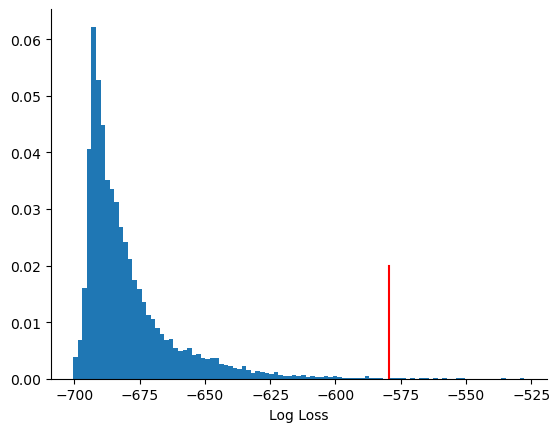

In [71]:
log_loss
fig, ax = plt.subplots()
bin_edges = np.linspace(np.percentile(shuff_results[:,0],1), np.percentile(shuff_results[:,0],100), num=100)
print(bin_edges[0], bin_edges[-1])

ax.hist(shuff_results[:,0], bin_edges, density=True)
ax.plot([log_loss, log_loss], [0, .02], color='red')
print(1- (log_loss>shuff_results[:, 0]).sum()/shuff_results.shape[0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Log Loss')

fig.savefig(os.path.join(figdir, "log_loss_histogram.pdf"))

In [17]:
result.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,1.9508,0.0799,,,
C(cond)[T.ctrl],M,2.7869,0.1079,,,
trial,M,-0.0682,0.0017,,,
trial:C(cond)[T.ctrl],M,-0.0193,0.0020,,,
int,V,0.1652,0.1787,1.180,0.825,1.686


0.013636363636363669


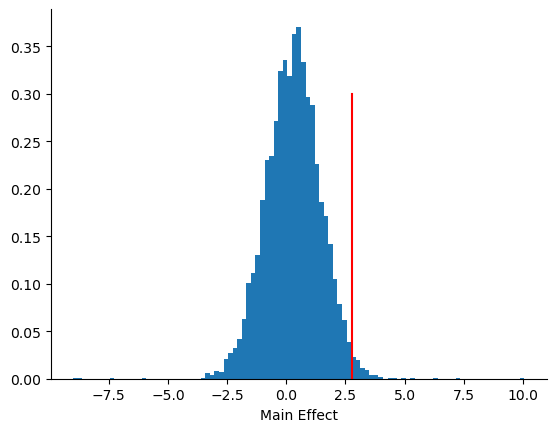

In [72]:
fig, ax =plt.subplots()
bins = np.linspace(np.amin(shuff_results[:,1]), np.amax(shuff_results[:,1]), num=100)
_= ax.hist(shuff_results[:,1],bins, density=True)
ax.plot(summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']*np.ones((2,)), [0, .3], color='red')
summ = result.summary()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print(1-(summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']>shuff_results[:,1]).sum()/shuff_results.shape[0])
ax.set_xlabel('Main Effect')

fig.savefig(os.path.join(figdir, "intercept_hist.pdf"))

0.8098776223776224


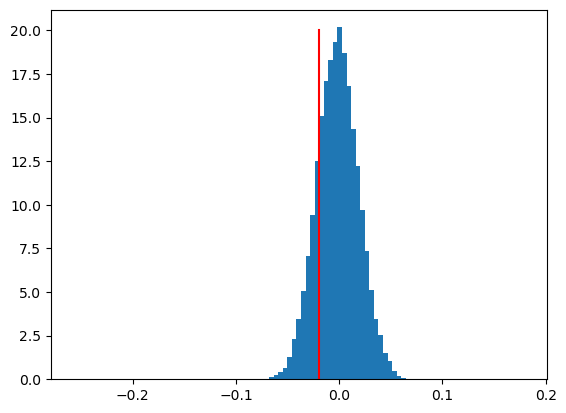

In [19]:
fig, ax =plt.subplots()
bins = np.linspace(np.amin(shuff_results[:,2]), np.amax(shuff_results[:,2]), num=100)
_= ax.hist(shuff_results[:,2],bins,density=True)
ax.plot(summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']*np.ones((2,)), [0, 20], color='red')
summ = result.summary()
print(1-(summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']>shuff_results[:,2]).sum()/shuff_results.shape[0])


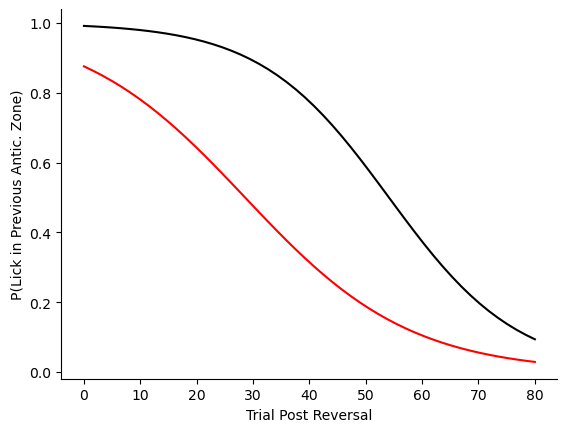

In [73]:
fig, ax = plt.subplots()
x = np.linspace(0,80)

intcpt = summ.tables[0]['Post. Mean']['Intercept']
cond_fe = summ.tables[0]['Post. Mean']['C(cond)[T.ctrl]']
trial_fe = summ.tables[0]['Post. Mean']['trial']
trial_cond_fe = summ.tables[0]['Post. Mean']['trial:C(cond)[T.ctrl]']

q = 1/(1+np.exp(-(intcpt + cond_fe + trial_fe*x + trial_cond_fe*x )))
ax.plot(x,q, color='black')
q = 1/(1+np.exp(-(intcpt + trial_fe*x )))
ax.plot(x,q, color='red')

ax.set_xlabel('Trial Post Reversal')
ax.set_ylabel('P(Lick in Previous Antic. Zone)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir, "mixed_model_fits.pdf"))

In [ ]:

# calculate log loss

# compare to log loss of model that just has an intercept and trial

In [ ]:
# run permutation test

# for each possible permutation of mice across conditions

# fit model

# return log loss and trial x condition beta value


